## Training point contributions (adapted from notebook by Chris)

From Rasmussen & Williams, the way that the mean of the PPD is calculated is through a linear combination of the values of the training function at each training point, where the coefficients for each training point are given by:

$$\bar{f_\star}=K(X_\star,X)K(X,X)^{-1}\mathbf{f}$$


In this notebook, we define these weights as $W(X_\star,X)\equiv K(X_\star,X)K(X,X)^{-1}$ and aim to plot them to give some visual representation of how a given emulator prediction is actually made from the training data. Whilst the above equation can be evaluated for a vector $f_\star$, essentially corresponding to making several emulator calls simulaneously at once, for simplicity in this case we evaluate it at just one point in parameter space. This means $K(X_\star,X)$ a row vector with each element being the covariance between the test point and each training point. Then the product of $K(X_\star,X)K(X,X)^{-1}=W(X_\star,X)$ is another row vector, where each entry represents the contribution to the linear combination of each training point, which is the quantity of interest in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import GPy

### Setting up the problem, and training data

Simple 1D example, where the truth is a sinusoidal function.

Main things to play with:
- fix_noise_var: if set to False, will let the optimizer tune it with the other hyper-parameters
- (x0,w): off-set and frequency parameters in the truth function
- size of training set
- kernel (linear, RBF, or combined)


In [2]:
# decide whether to optimise noise variance or use true value
fix_noise_var=True
# use small (6pts) or large (40 or more) training points
small_training=True
# specify kernel to use (RBF: Gaussian, lin: linear, com: combined)
kernel_type='RBF'

In [3]:
# define truth underlying function we are trying to model
def true_function(x,x0=2,w=4):
    return np.sin(w*(x-x0))

In [4]:
# define test data (_s stands for \star)
x_min=-2
x_max=x_min+4
n_s = 81
x_s = np.linspace(x_min,x_max,n_s).reshape(-1,1)

In [5]:
# training data (_t stands for training)
if small_training:
    x_t = [x_min+0.4,x_min+0.5,x_min+0.6,x_min+1,x_min+2.5,x_min+3]
else:
    n_t=41
    x_t = np.linspace(x_min,x_max,n_t)
n_t = len(x_t)
x_t = np.array(x_t).reshape(n_t,1)
# noise variance
noise_var=0.01
noise_rms=np.sqrt(noise_var)
y_t = true_function(x_t) + noise_rms*np.random.normal(size=[n_t,1])

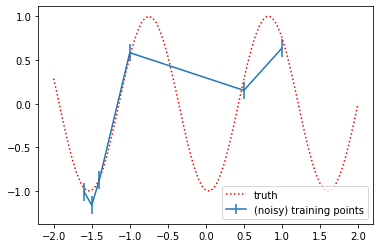

In [6]:
plt.errorbar(x_t,y_t,yerr=noise_rms*np.ones(n_t),label='(noisy) training points')
plt.plot(x_s,true_function(x_s),':',color='red',label='truth')
plt.legend()
plt.show()

### Setup the kernel and GP model

In [7]:
# choice the kernel
if kernel_type == 'RBF':
    kernel = GPy.kern.RBF(input_dim=1)
elif kernel_type == 'lin':
    kernel = GPy.kern.Linear(input_dim=1)
elif kernel_type == 'com':
     kernel = GPy.kern.RBF(input_dim=1) + GPy.kern.Linear(input_dim=1)
else:
    raise ValueError('wrong kernel_type: '+kernel_type)

In [8]:
# setup main GP model
m = GPy.models.GPRegression(x_t,y_t,kernel,noise_var=noise_var)
if fix_noise_var:
    m.Gaussian_noise.variance.fix()
m.optimize(messages=False)
display(m)

GP_regression.,value,constraints,priors
rbf.variance,0.41347030771020604,+ve,
rbf.lengthscale,0.23896182181602166,+ve,
Gaussian_noise.variance,0.01,+ve fixed,


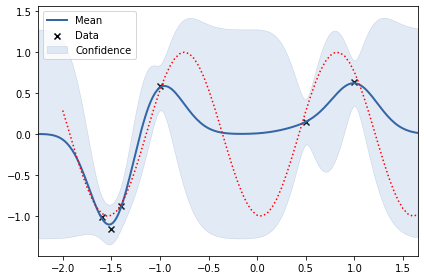

In [9]:
fig = m.plot()
plt.plot(x_s,true_function(x_s),':',color='red')
plt.show()

### Compute the contribution from each training point

From Rasmussen & Williams, the way that the mean of the PPD is calculated is through a linear combination of the values of the training function at each training point, where the coefficients for each training point are given by:

$$\bar{f_\star}=K(X_\star,X)K(X,X)^{-1}\mathbf{f} = W(X_\star,X) \mathbf{f}$$


In this notebook, we define these weights as $W(X_\star,X)\equiv K(X_\star,X)K(X,X)^{-1}$ and aim to plot them to give some visual representation of how a given emulator prediction is actually made from the training data. Whilst the above equation can be evaluated for a vector $f_\star$, essentially corresponding to making several emulator calls simulaneously at once, for simplicity in this case we evaluate it at just one point in parameter space. This means $K(X_\star,X)$ a row vector with each element being the covariance between the test point and each training point. Then the product of $K(X_\star,X)K(X,X)^{-1}=W(X_\star,X)$ is another row vector, where each entry represents the contribution to the linear combination of each training point, which is the quantity of interest in this notebook.

In [10]:
# concatenate test and training points
x_tot=np.concatenate((x_s,x_t),axis=0)
# Define kernel matrix:  K_ss=K(X*,X*), K_st=K(X*,X)
#                        K_ts=K(X,X*) , K_tt=K(X,X)
K_tot=m.kern.K(x_tot)
# with block matrices
K_st=K_tot[:n_s,n_s:]
K_tt=K_tot[n_s:,n_s:]
print('shape of K(X*,X) = ',K_st.shape)

shape of K(X*,X) =  (81, 6)


In [11]:
# compute covariance matrix of training points (including noise variance)
C_tt=K_tt+m.Gaussian_noise.variance*np.eye(n_t)

Text(0.5, 1.0, '$C(X,X)=K(X,X) + \\sigma_n^2 I$')

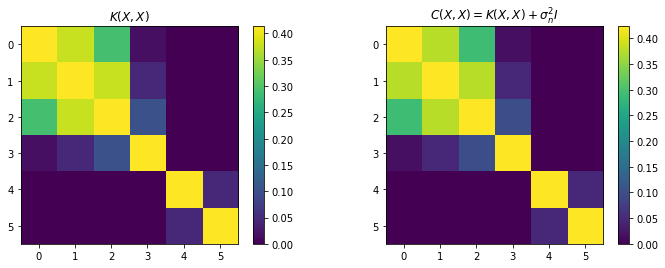

In [12]:
# visualize matrices
fig, axs = plt.subplots(1, 2,figsize=[12,4])
# plot K(X,X)
im0 = axs[0].imshow(K_tt)
plt.colorbar(im0,ax=axs[0])
axs[0].set_title(r'$K(X,X)$')
# plot C(X,X) including noise
im1 = axs[1].imshow(C_tt.transpose()[:,:8])
plt.colorbar(im1,ax=axs[1])
axs[1].set_title(r'$C(X,X)=K(X,X) + \sigma_n^2 I$')

Text(0.5, 1.0, '$C^{-1}(X,X)$')

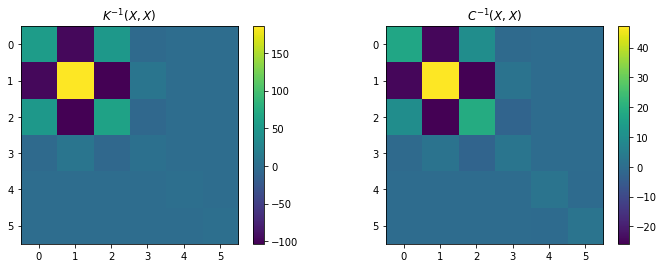

In [13]:
# compute and plot inverses
inv_K_tt=np.linalg.inv(K_tt) 
inv_C_tt=np.linalg.inv(C_tt) 
# visualize matrices
fig, axs = plt.subplots(1, 2,figsize=[12,4])
# plot K(X,X)
im0 = axs[0].imshow(inv_K_tt)
plt.colorbar(im0,ax=axs[0])
axs[0].set_title(r'$K^{-1}(X,X)$')
# plot C(X,X) including noise
im1 = axs[1].imshow(inv_C_tt.transpose()[:,:8])
plt.colorbar(im1,ax=axs[1])
axs[1].set_title(r'$C^{-1}(X,X)$')

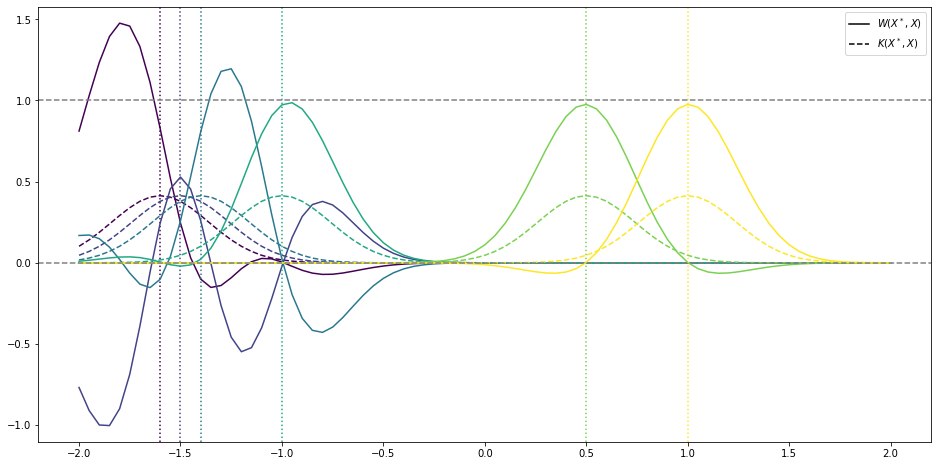

In [14]:
# compute and plot the weight matrix
W_st=np.matmul(K_st,inv_C_tt)
plt.figure(figsize=[16,8])
cmap=plt.get_cmap()
for i in range(n_t):
    color=cmap(i/(n_t-1))
    plt.plot(x_s,W_st[:,i],color=color,ls='-')
    plt.plot(x_s,K_st[:,i],color=color,ls='--')
    plt.axvline(x=x_t[i,0],color=color,ls=':')
plt.axhline(y=0,ls='--',color='gray')
plt.axhline(y=1,ls='--',color='gray')
plt.ylim(np.min(W_st)-0.1,np.max(W_st)+0.1)
plt.axhline(y=10,ls='-',color='black',label=r'$W(X^*,X)$')
plt.axhline(y=10,ls='--',color='black',label=r'$K(X^*,X)$')
plt.legend()
plt.show()

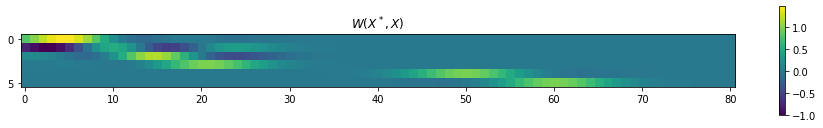

In [15]:
# plot whole weight matrix
plt.figure(figsize=[16,2])
plt.imshow(W_st.transpose())
plt.title(r'$W(X^*,X)$')
plt.colorbar()
plt.show()